<a href="https://colab.research.google.com/github/unknownpgr/road-simulator/blob/master/src/training/01_PyTorch_Learn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 01. PyTorch Learn
I wrote this scipt for pyTorch learning.

## Questions
- What is prop way to use Dataset and DataLoader?
    - Where augmentation should be?
- How exactly tqdm works?
- What is best model for lane position detection?
- How can i define my own loss function?
    - Actually, to adjust weight of label, proper number can be multiplied to label.
    - For example, if you double the first element of label, it will be trained more precisly than other elements.

## Import Libraries 

In [33]:
# Platform
from google.colab import drive
from IPython.display import clear_output

# Data preprocessing
import os
import cv2
import random
import numpy as np
import pandas as pd
import sklearn

# Training
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
import torchvision.transforms as T
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import KFold
from tqdm import tqdm

# Visualize
import matplotlib.pyplot as plt

## Prepare Dataset
Run this block after mounting Google Dirve.

This block will remove existing files, copy dataset zip file from google drive to collab, and extract dataset.

In [2]:
!rm -rf /content/dataset
!rm /content/dataset.zip
!cp "/content/drive/MyDrive/[2021]Computer Vision ML/data_regression.zip" /content/dataset.zip
!unzip /content/dataset.zip -d /content/dataset
clear_output()

## Configure Dataset Loader
`labels` parameter of `DatasetCustom` constructor is a dataframe of tuples `(file name, position, angle)`.

In [3]:
class ToTensor():
    def __call__(self,sample):
        image,label = sample
        # Swap color axis because axis order is:
        # Numpy image: H, W, C
        # Torch image: C, H, W
        image = image.transpose((2, 0, 1))
        return (torch.FloatTensor(image), torch.FloatTensor(label))

class DatasetCustom(Dataset):

    def __init__(self, dataset_root, labels, transforms=[ToTensor()]):
        self.label = np.array(labels[['position','angle']], dtype=np.float32)
        self.input = list(map(lambda x:os.path.join(dataset_root, x).replace('\\','/'), labels['input']))
        self.transforms = T.Compose(transforms)

    def __len__(self):
        return len(self.label)
  
    def __getitem__(self, index):
        path = self.input[index]
        image = cv2.imread(path).astype('float')/255
        label = self.label[index]

        sample = (image, label)
        sample = self.transforms(sample)

        return sample

## Construct Traning Model

In [51]:
class MultiLabelResnet(nn.Module):
    def __init__(self):
        super(MultiLabelResnet, self).__init__()

        # Define model structure at once by using nn.ModuleList.
        self.layers = nn.ModuleList([
                                     nn.Conv2d(3, 3, 3, stride=1),
                                     nn.LeakyReLU(),
                                     models.resnet18(),
                                     nn.LeakyReLU(),
                                     nn.Linear(1000 ,128),
                                     nn.LeakyReLU(),
                                     nn.Linear(128 ,32),
                                     nn.LeakyReLU(),
                                     nn.Linear(32 ,8),
                                     nn.LeakyReLU(),
                                     nn.Linear(8 ,2),
                                     nn.LeakyReLU(),
                                     ])

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

# Create model just for test
model_test = MultiLabelResnet()
print(model_test)
del model_test

MultiLabelResnet(
  (layers): ModuleList(
    (0): Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1))
    (1): LeakyReLU(negative_slope=0.01)
    (2): ResNet(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (1): BasicBlock(
          (conv1): Co

## Define Dataset
Make traning dataset and validation dataset by splitting whole label into two parts.

`label.csv` is a list of tuples `(file name, position, angle)`.

In [7]:
ROOT = 'dataset'
VALID_RATIO = 0.2

labels = pd.read_csv(os.path.join(ROOT, "label.csv"))
labels = sklearn.utils.shuffle(labels)

valid_count = int(len(labels)*VALID_RATIO)

valid_dataset = DatasetCustom(ROOT, labels[:valid_count])
train_dataset = DatasetCustom(ROOT, labels[valid_count:])

## Set Traning Device
Use GPU if possible. Else, use CPU instead.

In [10]:
is_cuda_available = torch.cuda.is_available()
device = torch.device("cuda:0" if is_cuda_available else "cpu")

if is_cuda_available:
    print('CUDA is available and the device was set to GPU.')
else:
    print('CUDA is not available and the device was set to CPU.')

CUDA is available and the device was set to GPU.


## Configure Traning Environment
Traning environment configuration part and traning part are spearated so that traning can be done multiple times without reinitializing model.

In [17]:
# Define data loaders.
train_data_loader = DataLoader(
    train_dataset,
    batch_size = 128,
    shuffle = False,
    num_workers = 3
)

valid_data_loader = DataLoader(
    valid_dataset,
    batch_size = 32,
    shuffle = False,
    num_workers = 3
)

# Define  model and move it to traning device.
model = MultiLabelResnet()
model.to(device)

# Define optimzer.
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)    

# Define learning rate scheduler. It will automatically adjust learning rate.
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size = 5,
                                               gamma = 0.75)

# Define loss function.
criterion = torch.nn.MSELoss()

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
Valid Epoch 9: 100%|██████████| 23/23 [00:01<00:00, 22.38batch/s, valid_loss=0.884]


## Train Model
valid_loss_min should be sustained so that it is in separated block. The training part below can be run multiple times.

In [43]:
valid_loss_min = float('inf')

In [49]:
for epoch in range(10):
  
    with tqdm(train_data_loader, unit="batch") as train_bar:
        train_bar.set_description(f"Train Epoch {epoch}")

        # Train one epoch
        train_loss_list = []
        for sample in train_bar:

            # For each sample(batch), initialize gradients.
            optimizer.zero_grad()

            # Split images and labels, and move it to device.
            images, labels = sample
            images = images.to(device)
            labels = labels.to(device)

            # Set model to training mode.
            model.train()

            # Enable gradients.
            with torch.set_grad_enabled(True):
                # Predict results.
                predicts  = model(images)

                # Calculate loss.
                loss = criterion(predicts, labels)

                # Update delta with back-propagation.
                loss.backward()

                # Training model with optimzer.
                optimizer.step()

            # Add loss(which is just single number) to train loss list.
            train_loss_list.append(loss.item())

            # Get average of loss and display it on progress bar.
            train_loss = np.mean(train_loss_list)
            train_bar.set_postfix(train_loss = train_loss)
            
    # Adjust learning rate after training one epoch.
    lr_scheduler.step()

    # Calculate validation score after training one epoch.
    with tqdm(valid_data_loader, unit="batch") as valid_bar:
        valid_bar.set_description(f"Valid Epoch {epoch}")
 
        valid_loss_list = []
        for sample in valid_bar:
            optimizer.zero_grad()

            images, labels = sample
            images = images.to(device)
            labels = labels.to(device)

            # Unlike traning, set model to evaluation mode and disable gradients.
            model.eval()
            with torch.no_grad():
                predicts  = model(images)
                loss = criterion(predicts, labels)
                valid_loss_list.append(loss.item())

            valid_loss = np.mean(valid_loss_list)
            valid_bar.set_postfix(valid_loss = valid_loss)
        
    # If current model is in best state, store it.
    if valid_loss < valid_loss_min:
        valid_loss_min = valid_loss
        model_name = "resnet18"
        path = "/content/drive/MyDrive/[2021]Computer Vision ML/"
        torch.save(model, f'{path}[{model_name}] Loss[{valid_loss:2.4f}] Epoch[{epoch}].pth')

Train Epoch 0:   0%|          | 0/23 [00:00<?, ?batch/s]/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
Valid Epoch 9: 100%|██████████| 23/23 [00:00<00:00, 24.50batch/s, valid_loss=0.111]


## Test Trained Model

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


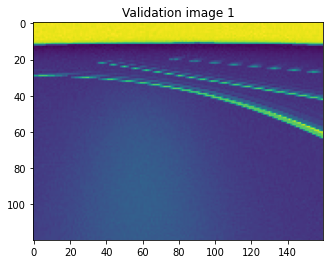

Prediction: [ 2.148894   -0.00929057] Label: [ 2.0366385 -0.2306814]
Relative error: 5.5118% -95.9726%



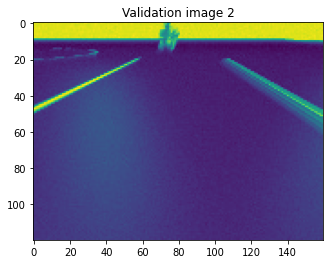

Prediction: [ 1.433685   -0.00548929] Label: [1.3516424  0.02800324]
Relative error: 6.0698% -119.6023%



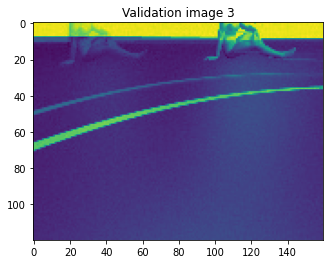

Prediction: [ 1.5295174  -0.00780466] Label: [ 1.5768963 -0.2509602]
Relative error: -3.0046% -96.8901%



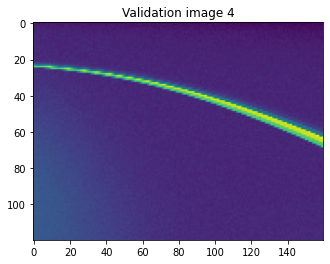

Prediction: [ 1.458469   -0.00710985] Label: [1.1276495  0.10022771]
Relative error: 29.3371% -107.0937%



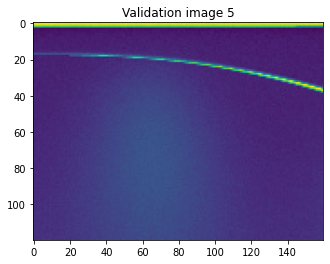

Prediction: [-5.1215     -0.02021183] Label: [-5.8778377  0.022219 ]
Relative error: -12.8676% -190.9665%



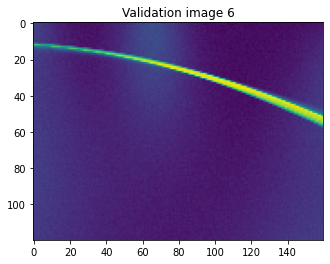

Prediction: [ 1.4038323  -0.00741961] Label: [1.2074772  0.06201015]
Relative error: 16.2616% -111.9652%



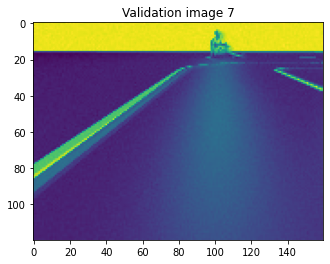

Prediction: [-5.1939483  -0.01791996] Label: [-5.403534    0.13398434]
Relative error: -3.8787% -113.3747%



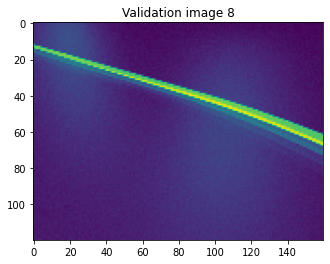

Prediction: [ 1.5502031  -0.00735685] Label: [ 1.5755969  -0.18251444]
Relative error: -1.6117% -95.9692%



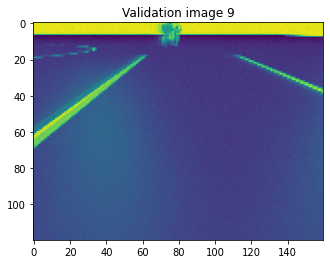

Prediction: [-5.646511   -0.01929363] Label: [-5.994660e+00 -1.432056e-03]
Relative error: -5.8076% 1247.2677%



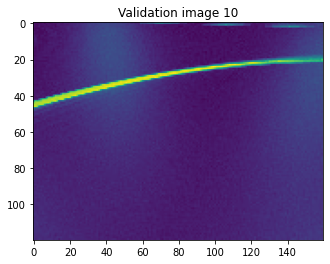

Prediction: [ 6.1854067  -0.00756458] Label: [6.1387463  0.09836131]
Relative error: 0.7601% -107.6906%



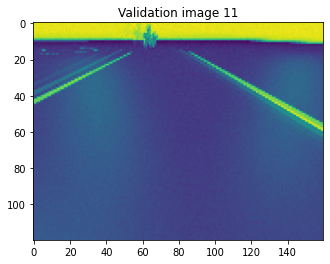

Prediction: [ 1.5557314  -0.00677018] Label: [1.2832208 0.0666627]
Relative error: 21.2365% -110.1559%



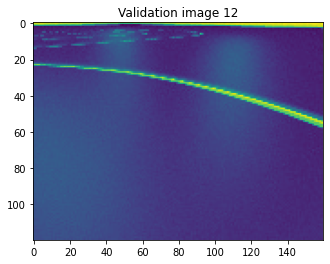

Prediction: [-1.578591   -0.00855105] Label: [-1.6260844  -0.10148769]
Relative error: -2.9207% -91.5743%



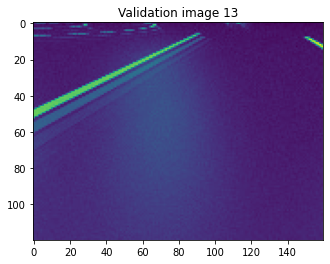

Prediction: [ 0.56597865 -0.00945102] Label: [0.986916   0.25926295]
Relative error: -42.6518% -103.6453%



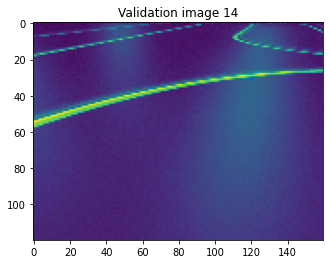

Prediction: [ 3.0957642  -0.00670952] Label: [ 3.4174602  -0.02031371]
Relative error: -9.4133% -66.9705%



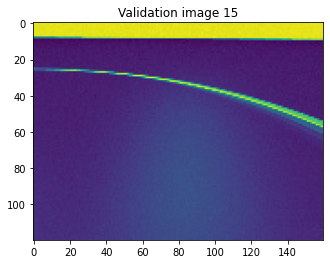

Prediction: [ 0.4960029  -0.01984205] Label: [ 1.0276289  -0.18921578]
Relative error: -51.7333% -89.5135%



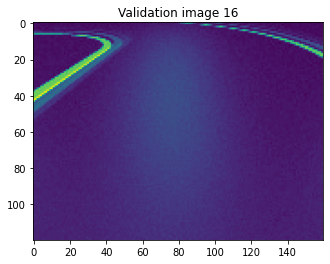

Prediction: [-2.7703023  -0.01251793] Label: [-3.0072892  -0.05315111]
Relative error: -7.8804% -76.4484%



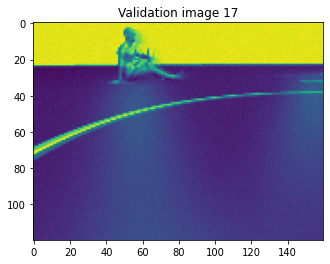

Prediction: [-3.9709861 -0.0142973] Label: [-5.774683   -0.18823238]
Relative error: -31.2346% -92.4044%



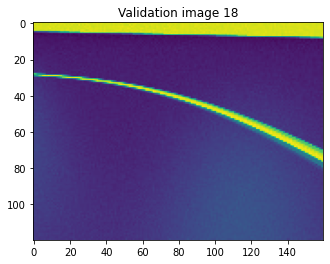

Prediction: [ 3.528086   -0.00533114] Label: [ 3.8446329  -0.15703309]
Relative error: -8.2335% -96.6051%



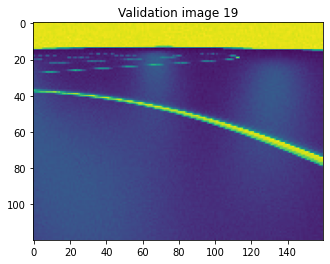

Prediction: [ 0.28469682 -0.0113637 ] Label: [0.45958298 0.02726077]
Relative error: -38.0532% -141.6852%



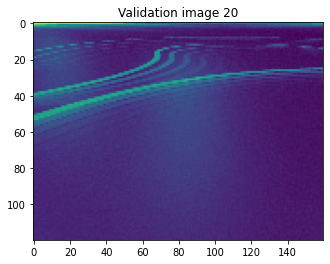

Prediction: [ 2.2558177  -0.00644086] Label: [3.7830973  0.17803858]
Relative error: -40.3711% -103.6177%



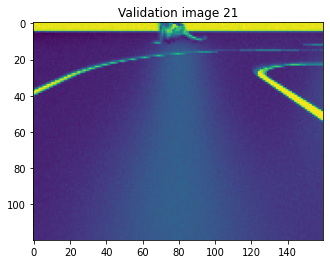

Prediction: [ 3.4753695  -0.00529483] Label: [3.460891   0.01875304]
Relative error: 0.4183% -128.2345%



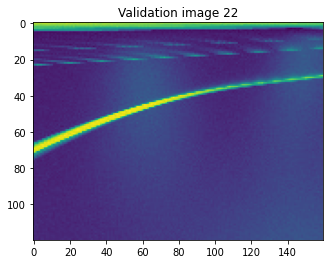

Prediction: [-1.7646463  -0.00826442] Label: [-1.7309906   0.15148287]
Relative error: 1.9443% -105.4557%



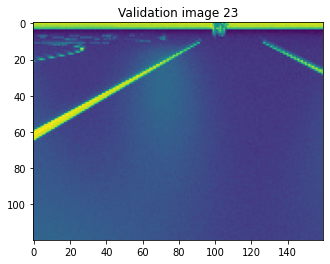

Prediction: [-2.2824686  -0.00922398] Label: [-1.8310919  0.2292298]
Relative error: 24.6507% -104.0239%



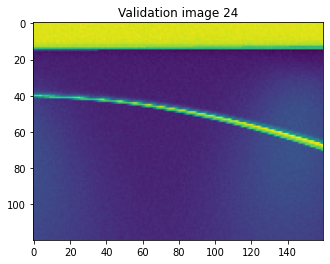

Prediction: [-4.5288987  -0.01615775] Label: [-4.0004244   0.02919196]
Relative error: 13.2105% -155.3500%



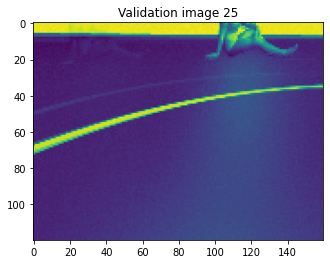

Prediction: [ 0.21148466 -0.01411418] Label: [ 0.4443697  -0.24621089]
Relative error: -52.4080% -94.2674%



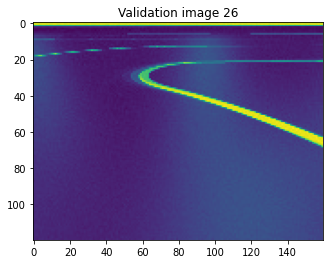

Prediction: [ 0.7503919  -0.01002012] Label: [0.9182247  0.00962867]
Relative error: -18.2780% -204.0655%



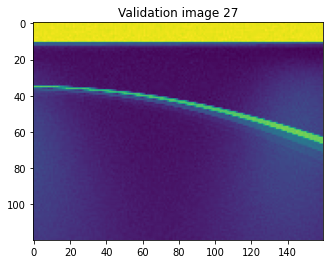

Prediction: [-3.3680217  -0.01263544] Label: [-2.7624805  -0.04462701]
Relative error: 21.9202% -71.6866%



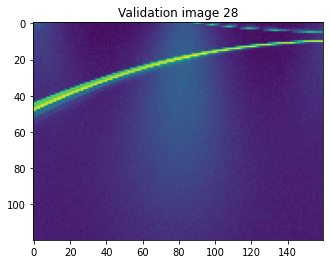

Prediction: [-0.7318021  -0.00637503] Label: [-0.9479572  0.213453 ]
Relative error: -22.8022% -102.9866%



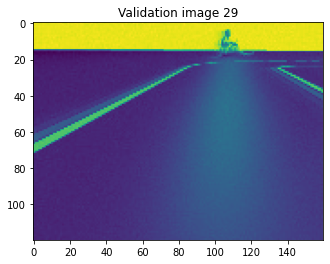

Prediction: [-0.534352   -0.00746978] Label: [-0.92179483  0.1905437 ]
Relative error: -42.0313% -103.9202%



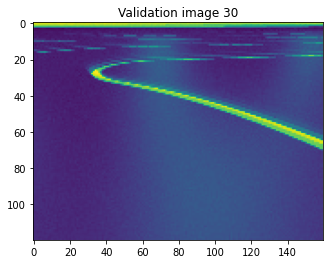

Prediction: [ 0.68168205 -0.00992573] Label: [0.47512618 0.0586422 ]
Relative error: 43.4739% -116.9259%



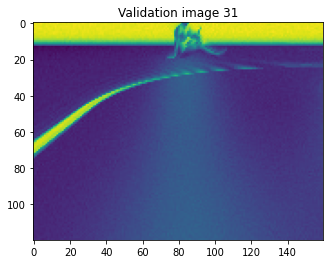

Prediction: [-5.6686106  -0.01946875] Label: [-5.7621727   0.00805408]
Relative error: -1.6237% -341.7253%



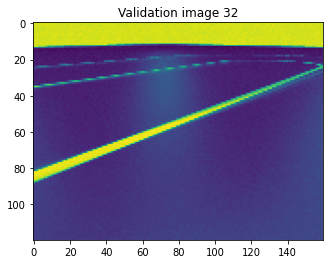

Prediction: [-0.7503446  -0.00545204] Label: [-0.9799833  -0.22519691]
Relative error: -23.4329% -97.5790%



In [56]:
# Get sample data
index, sample = next(enumerate(valid_data_loader))
images, labels = sample

# Move it to device
images = images.to(device)
labels = labels.to(device)

# Predict
optimizer.zero_grad()
model.eval()
with torch.no_grad():
    predicts = model(images)

# Get images, labels and prediction results to cpu, and convert them to numpy array.
images = images.cpu().detach().numpy()
labels = labels.cpu().detach().numpy()
predicts = predicts.cpu().detach().numpy()

# For each cases,
for i in range(len(labels)):
    
    # Display image
    plt.imshow(images[i][0])
    plt.title(f"Validation image {i+1}")
    plt.show()

    # Print some data
    print('Prediction:',predicts[i], 'Label:', labels[i])
    print('Relative error:', *list(map(lambda x:f'{x:2.4f}%',np.divide(predicts[i]-labels[i],labels[i])*100)))
    print()
        
    